## **Transformers for Language Modeling**

<center>
    <img src="./assets/transformers.png">
</center>

### Introduction

In this notebook, you will be implementing a Transformer, `MiniGPT`, from scratch. This will be taken from the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). You will then train this Transformer on a language modeling task on a dataset of your choosing.

After this notebook, you should be able to:

- Understand how Transformers, and all its components, are implemented in code.

- Train a Transformer on a language modeling task.

- Brag on Twitter about how you created a Transformer from scratch.

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions and Plagiarism Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span> We will be using the `print` statements to grade your assignment.

- <span style="color: red;">You must attempt all parts.</span> Do not assume that because something is for 0 marks, you can leave it - it will definitely be used in later parts.

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import tiktoken
from google.colab import drive

import torch.optim as optim
import re
import nltk
from nltk.corpus import stopwords
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Creating a Dataset

In this section, you will be creating a dataset for training your Transformer. You are allowed to use any dataset you want, as long as it is a text dataset.

Some fun options include:

- A collection of movie scripts from your favorite director. Look through [IMSDB](https://www.imsdb.com/) for some options.

- A novel from your favorite author. Look through [Project Gutenberg](https://www.gutenberg.org/) for some options.

- A collection of poems from your favorite poet. Look through [Poetry Foundation](https://www.poetryfoundation.org/) for some options.

- Anything else from [Kaggle](https://www.kaggle.com/datasets) or [HuggingFace](https://huggingface.co/datasets).

You are not allowed to be boring and use the same dataset as something previously seen in the course.

This section involves doing the following:

1. **Finding/Downloading/Creating your dataset**. Add in a few comments about what it is and why you chose it. (10 Marks)

2. **Preprocessing your dataset**. This involves tokenizing your dataset, and creating a vocabulary. Previously you used character-level tokenization, now you will use **subword-level tokenization** (you can read about different tokenization strategies [here](https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt)). This can be very easily handled with the `tiktoken` library (read up [here](https://github.com/openai/tiktoken)), which is also what the GPT family uses :p (10 Marks)

**Note:** Do not use character-level tokenization (what you used in the previous assignment).

In [ ]:
#preprocessing text dunction
# This dataset consists of novels: Harry Potter Series, LOTR Series and Game of Thrones. I chose this dataset because these novels are one of the best reads of my collection so
# far, especially LOTR.

def remove_special_char(txt):
  return re.sub(r'�', '', txt)

def remove_numbers(txt):

    return re.sub(r'\d+', '', txt)

def remove_url(txt):

    return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', txt)

def normalize_sentence(txt):
    '''
    Aggregates all the above functions to normalize/clean a sentence
    '''

    return remove_url(remove_special_char(remove_numbers(txt)))

In [ ]:
BATCH_SIZE = 32
BLOCK_SIZE = 8

# Create tiktoken object
encoder = tiktoken.get_encoding("gpt2")

# TODO: Read in your dataset
path = "/content/drive/MyDrive/novels.txt"
with open(path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

script = ''.join(lines)

#preprocessing script
script = normalize_sentence(script)

# TODO: Create the encoded ids using the encoder
ids = encoder.encode(script)


# TODO: Complete the get_batch function
def get_batch():
    '''
    Returns a batch (x, y) from the dataset
    '''
    # TODO: Get random integers for indexing into the dataset to create a batch
    indices = np.random.randint(0, len(ids)-BLOCK_SIZE - 1, BATCH_SIZE)
    # TODO: Get the x and y (input and target) batches after encoding and indexing
    x = [ids[i:i + BLOCK_SIZE]for i in indices]
    y = [ids[i+1:i+BLOCK_SIZE+1]for i in indices]
    # TODO: Make sure these are int64 (long) tensors
    x = torch.tensor(x, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    return x, y

xb, yb = get_batch()
xb.shape, yb.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

## Creating the Transformer

### Defining our Hyperparameters

We will define our hyperparameters here. You can play around with these later to see how they affect your model.

Since there are lots of hyperparameters to keep track of, it is easier for us to wrap all of them inside a `dataclass`. This can be passed around very easily to different functions, and makes it easier to keep track of all relevant values.

To quickly describe some of the hyperparameters:

1. `block_size`: This is the length of the sequence that we will be feeding into our model. This has also been called the *context length* and *window size* in other places.

2. `emb_dim`: This is the dimensionality of the embeddings we will have inside the model. This has implications on the outputs of tensors throughout the entire model.

3. `head_size`: When dealing with Multi-Head Attention, we will be *splitting* our embeddings into multiple heads. This is the size of each of those heads. For example, if we had an embedding of size 512, and we wanted 8 heads, then each head would have a size of 64. Down the line, we'd be concatenating these heads together, so the final output would be of size 512 again, as you should recall from the lectures.

4. `num_heads`: This is the number of attention heads we will have in our Multi-Head Attention layer.

5. `num_layers`: This is the number of layers we will have in our Transformer (this includes the MHSA, the Feedforward module, and the Layer Normalizations).

6. `vocab_size`: This is the size of our vocabulary. This is the number of unique tokens we have in our vocabulary. If you were to use character-level tokenization, this would be the number of unique characters in your dataset. Since you should be using subword-level tokenization, this will be the number of unique subwords in your dataset.

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = encoder.n_vocab # vocab size of the tokenizer

# We like to have emb_dim == head_size * num_heads
config = Config()
assert config.emb_dim == config.head_size * config.num_heads, "Embedding dimension must be divisible by number of heads"

### Multi-Head Self-Attention

This component is the core of the Transformer. This is where the model learns to attend to different parts of the input sequence, and is the reason why Transformers are so powerful.

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$$\text{head}_k = \text{Attention}(QW^Q_k, KW^K_k, VW^V_k)$$

$$\text{MHSA}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

For simplicity, assume we have a single Head:

1. The input has three parts extracted from it: the query $Q$, the key $K$, and the value $V$ (via projections or `Linear` layers).

2. The query and key are multiplied together to get a score. This score is then scaled by the square root of the embedding dimension, $\sqrt{d_k}$, then passed through a softmax to get the attention weights (*after* a masking operation is applied).

3. The attention weights are then multiplied with the value to get the final output.

When we extend this to *multiple heads*, we simply repeat this process for each head in parallel, and then concatenate the outputs of each head together.

Create a class for this `MHSA` module (Multi-Head Self-Attention), adding a comment next to each line in the `forward` method for the shape of the tensor at that point. This will help you debug later on.

In [ ]:
class MHSA(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg.emb_dim
        self.head_size = cfg.head_size
        self.block_size = cfg.block_size
        self.num_heads = cfg.num_heads

        # TODO: Define the single projection layer for QKV
        self.layer_qkv = nn.Linear(self.emb_dim, 3* self.emb_dim)
        # TODO: Define the output projection layer
        self.output = nn.Linear(self.emb_dim, self.emb_dim)
        # Create a buffer for the mask (buffers are tensors that are not updated during backpropagation)
        self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size)))

    def forward(self, x):

        B, T, C = x.shape # batch size, block size, emb dim
        H = self.num_heads

        # TODO: Carry out the projections to get the query, key and value - you may want to reshape them to (B, H, T, head_size) to make things easier
        projection = self.layer_qkv(x).view(B, T,H,3*self.head_size)
        projection = projection.view(B,T,3,H,self.head_size).permute(0,3,1,2,4)
        query, key, value = projection.split([1,1,1], dim=-2)
        # for easier processing we cut the dimensions into chunks for faster MHSA implementation (as fast as single head attention)
        query = query.view(B,H,T,-1)
        key = key.view(B,H,T,-1)
        value = value.view(B,H,T,-1)
        # TODO: Compute the attention scores, perform masking, and apply the softmax
        scores = torch.matmul(query, key.transpose(-2,-1))/(self.head_size**0.5)
        scores = scores.masked_fill(self.mask[:T, :T]==0, float('-inf'))
        probs = torch.nn.functional.softmax(scores, dim=-1)
        # TODO: Compute the weighted sum of the value vectors - you can perform the concatenation via a simple reshaping before applying the final projection
        weighted_sum = probs @ value
        out = weighted_sum.permute(0,2,1,3).contiguous().view(B,T,-1)
        out = self.output(out)
        return out

# !DO NOT REMOVE THESE LINES!
x = torch.randn(32, config.block_size, config.emb_dim)
print(x.shape)
csa = MHSA(config)
out = csa(x)
print(out.shape)

torch.Size([32, 8, 256])
torch.Size([32, 8, 256])


### Feedforward Network

The Feedforward Network module usually consists of two linear layers, with a ReLU activation in between. The first linear layer projects the input's Embeddings to a higher dimensionality (by a factor of 4 specifically), and the second linear layer projects it back down to the original dimensionality. This is a very simple module, but is very effective in learning complex functions.

Create a class for this `Feedforward` module, with the following tweaks:

1. Use the [GELU Activation Function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) instead of ReLU between the layers. It is functionally very similar, but has gained a lot of popularity recently.

2. Instead of using two `Linear` layers, and an upsampling factor of `4`, use **three** `Linear` layers: the first one upsamples by a factor of `2`, the second one does not change the dimensionality, and the third one downsamples by a factor of `2`. This creates a slightly deeper network, and can be shown to have the same number of parameters as the network in the original Transformer.

3. Add a [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) after the last `Linear` layer, with $p=0.1$. This helps mitigate overfitting.

In [ ]:
class Feedforward(nn.Module):
    def __init__(self, config):
        super().__init__()
        emb_dim = config.emb_dim

        # TODO: Define the feedforward network
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, emb_dim *2),
            nn.GELU(),
            nn.Linear(emb_dim*2, emb_dim*2),
            nn.GELU(),
            nn.Linear(emb_dim*2, emb_dim),
            nn.Dropout(p=0.1)
        )

    def forward(self, x):
        # TODO: Apply the feedforward network
        x = self.feedforward(x)
        return x

### Blocks with Skip Connections

The Encoder consists of multiple *Blocks*, that each contain a Multi-Head Self-Attention module, a Feedforward module, and a Layer Normalization module. We use Skip Connections to help with the flow of gradients during the training process.

Create a class for this `Block` module, with the following tweaks:

- Instead of creating your own Layer Normalization module, use [the one provided by PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), `nn.LayerNorm`.

- Perform the Layer Normalizations **before** the Skip Connections, instead of after. The original paper used the "post-LN" approach, but [recent research](https://arxiv.org/abs/2002.04745) has shown that the "pre-LN" approach is better.

In [ ]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        # TODO: Define the MHSA, Feedforward, and two LayerNorm modules
        self.mhsa = MHSA(config)
        self.feedforward = Feedforward(config)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
    def forward(self, x):

        # TODO: Apply the modules with residual connections (use the Pre-LN design)
        x = self.mhsa(self.norm1(x))
        x = self.feedforward(self.norm2(x))
        return x

# !DO NOT REMOVE THESE LINES!
x = torch.randn(8, config.block_size, config.emb_dim)
print(x.shape)
block = Block(config)
out = block(x)
print(out.shape)

torch.Size([8, 8, 256])
torch.Size([8, 8, 256])


### Putting it all together

Now that we have all the components, we can put them together to create the Transformer. The Transformer consists of

1. Creating Embeddings for the input sequence. This implies turning the input sequence into a sequence of indices, and then passing it through an `nn.Embedding` layer. Alongside this, we will be using another Embedding table for the positional encodings. For simplicity, we can keep the embedding dimensionality for both of these the same.

2. Passing the embeddings through a series of Blocks.

3. Passing the output of the Encoder through a Layer Normalization layer, and then a Linear layer to get the final logits.

Create a class for this `SastaGPT` module. This will be the final model that we will be training. Note that the `generate()` function has been provided for you.

In [ ]:
class MiniGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.block_size = config.block_size
        self.num_layers = config.num_layers
        self.vocab_size = config.vocab_size

        # TODO: Define the word and position embeddings
        # Hint: They will both have the same embedding dimension, only difference is the number of embeddings (vocab_size vs. block_size)
        self.word = nn.Embedding(config.vocab_size, config.emb_dim)
        self.position = nn.Embedding(config.block_size, config.emb_dim)
        # TODO: Define the sequence of Blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range (config.num_layers)])
        # TODO: Define the final LayerNorm
        self.final = nn.LayerNorm(config.emb_dim)
        # TODO: Define the final linear layer (to get logits)
        self.final_logits = nn.Linear(config.emb_dim, config.vocab_size)
        # Initialize the weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idxs):
        # idxs: (B, T)
        batch_size, seq_len = idxs.shape

        assert seq_len <= self.block_size, f"Sequence length exceeds block size of {self.block_size}"

        # TODO: Get the word embeddings (B, T, C) and position embeddings (T, C)
        # Hint: For the position embeddings, you can use torch.arange(seq_len) to mimic the indices
        # Note: position embeddings are encodings of the position indices (NOT the actual tokens)
        word_emb = self.word(idxs)
        position_ind = torch.arange(seq_len, device=idxs.device).unsqueeze(0)
        position_emb = self.position(position_ind)
        # TODO: Add the word and position embeddings (broadcasting will take care of the shapes)
        embed = word_emb + position_emb
        # TODO: Pass the embeddings through the blocks (B, T, C)
        for block in self.blocks:
          embed = block(embed)
        # TODO: Apply the final LayerNorm
        embed = self.final(embed)
        # TODO: Apply the final linear layer to get the logits (B, T, V)
        logits = self.final_logits(embed)
        return logits

    @torch.no_grad()
    def generate(self, idxs, max_new_tokens=20):
        '''
        Takes in a sequence of indices (the tokenized sentence) and generates new tokens
        Note that the input indices should not be longer than the block size
        Returns the input sequence with the generated tokens appended (these should be decoded using the Tokenizer)

        Params
        ------
        idxs: torch.Tensor
            (B, T) tensor of token indices
        max_new_tokens: int
            Maximum number of new tokens to generate
        '''

        # idxs: (B, T)
        for _ in range(max_new_tokens):
            idxs_trimmed = idxs[:, -self.block_size:] # trim to block size

            logits = self(idxs_trimmed) # (B, T, V)

            logits = logits[:, -1, :] # (B, V)

            probs = F.softmax(logits, dim=-1) # (B, V)

            next_idx = torch.multinomial(probs, num_samples=1) # (B, 1)

            idxs = torch.cat((idxs, next_idx), dim=1) # (B, T+1)

        return idxs

cfg = Config()
model = MiniGPT(cfg)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1e6 :.3f}M")

Number of parameters: 27.364M


In [ ]:
# !DO NOT REMOVE THESE LINES!

# Check out the forward pass
xb, yb = get_batch()
print(xb.shape)

logits = model(xb)
print(logits.shape) # (B, T, V)

torch.Size([32, 8])
torch.Size([32, 8, 50257])


Now train this model on your own dataset!

Note that since the model is quite large, it will take a while to train. This would be a good opportunity to use [Google Colab](https://colab.research.google.com/) or [Kaggle Notebooks](https://www.kaggle.com/notebooks) for free GPU compute. This requires very few changes to your original training code, only having to cast your model and data to the GPU.

```python
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the batch
xb, yb = get_batch()

# Cast to the device
xb = xb.to(device)
yb = yb.to(device)

# Cast the model to the device
model = model.to(device)

# Forward pass
preds = model(xb)

...

```

The only rule is that both your model and your tensors should be on the same device (CPU or GPU).

In [ ]:
# TODO: Train the model

# we use the general criteria to train the model using loss function, optimizer epoch loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)


epochs = 500
for epoch in range(epochs):
  for i in range(300):
    model = model.to(device)
    model.train()
    xb, yb = get_batch()
    xb = xb.to(device)
    yb = yb.to(device)
    logits = model(xb)
    loss_ = loss(logits.view(-1, cfg.vocab_size), yb.view(-1))
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
  if epoch%10==0:
    print(f"Epoch {epoch+1}, Loss: {loss_.item()}")


Epoch 1, Loss: 6.643047332763672
Epoch 11, Loss: 6.80014181137085
Epoch 21, Loss: 6.876214027404785
Epoch 31, Loss: 6.594824314117432
Epoch 41, Loss: 6.64005184173584
Epoch 51, Loss: 6.542564868927002
Epoch 61, Loss: 6.972264766693115
Epoch 71, Loss: 6.897254943847656
Epoch 81, Loss: 6.559534549713135
Epoch 91, Loss: 6.568901062011719
Epoch 101, Loss: 6.5400710105896
Epoch 111, Loss: 6.485126972198486
Epoch 121, Loss: 6.694623947143555
Epoch 131, Loss: 5.801972389221191
Epoch 141, Loss: 5.990728378295898
Epoch 151, Loss: 5.318575859069824
Epoch 161, Loss: 5.378993034362793
Epoch 171, Loss: 4.990650177001953
Epoch 181, Loss: 4.4938554763793945
Epoch 191, Loss: 5.372264862060547
Epoch 201, Loss: 4.832192420959473
Epoch 211, Loss: 4.89767599105835
Epoch 221, Loss: 5.119926929473877
Epoch 231, Loss: 5.139658451080322
Epoch 241, Loss: 4.614809036254883
Epoch 251, Loss: 4.940868377685547
Epoch 261, Loss: 4.842645645141602
Epoch 271, Loss: 4.836676120758057
Epoch 281, Loss: 5.004046440124512


With your trained model, generate some text. You can use the `generate()` function provided to you.

Note that the quality of your generations depends on:

- How large the training dataset was. If you used a small dataset, your model will not have enough samples to learn the syntax, semantics, the grammar and other intricacies of language, much less the specifics of the dataset.

- How long you trained for. Provided your dataset was large enough, you could try training for longer epochs until the loss values stabilize.

- How large your model was. If you used a small model, it will not have enough parameters to learn the complexities of language. You can try increasing the number of layers, the embedding dimensionality, the number of heads, etc.

Most importantly, share your generations with the rest of the class! Take some screenshots of your best generations, and share them on the Slack channel.

In [ ]:
# Check out the generate method
sentence = "And"
idxs = torch.tensor(encoder.encode(sentence)).unsqueeze(0)
idxs = idxs.to(device)

model.eval()
generated = model.generate(idxs, max_new_tokens=250)
generated_cpu = generated.to('cpu')
res = encoder.decode(generated_cpu[0].numpy())
print(res)

And I was so far down with all ear, andest Elm seen, then a hundred my body nor Joffists had not seen the platform and connected fire from the spring of the hollowwood and poured over the darkness. "If then Harry! said Harry, but Hermione brushed her shield into the lake.

“Tell me to go no further here at him. Let him want got off and a boy to his heels consted sword, when he disappeared right.

The ropes was still long a tapolt to hobbling at Harry's disbelief… “Is it at your ridden into me. And fight today I would not hear the postened hunters from the middle of the water moving in the water, because the north, though the same sight of flowers dwell step more green steel against his head. Once.

Would they thought she is ill,' said Aragorn. 'We're leading your best share the Old Bear quicker Sansa had known that that storm myself again also shouted free, pounding it?'
     But at birth do be hard to leave a real dreams can take somestanding?”

“A handsome king die-elf right through 

## Effects of Hyperparameters on the Number of Parameters

In this section, you will be exploring the effects of the hyperparameters on the number of parameters in your model.

With so much room for tweaking (with the embedding dimensionality, the size of the vocab, the number of heads, the number of layers, etc.), it is important to visualize how fast the total number of parameters can grow if you start toying with them.

In [ ]:
def get_params(model):
    '''
    Returns the number of parameters in the model (in millions)
    '''
    return sum(p.numel() for p in model.parameters()) / 1e6

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = 100 # smaller vocab size for quick prototyping

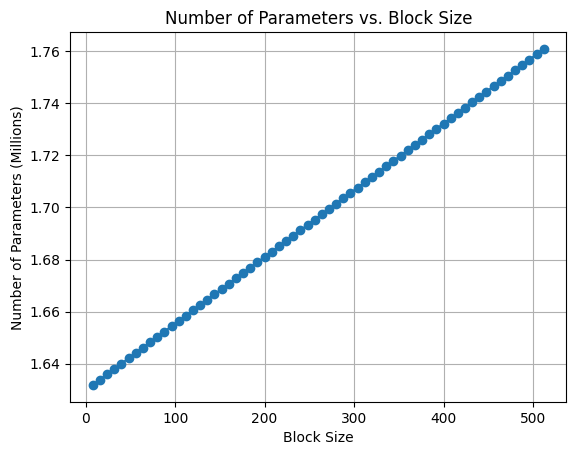

In [ ]:
# TODO: Plot the number of parameters vs. block size (in multiples of 8, capped at 512)
block_Size = list(range(8, 513, 8))
num_params_list = []

for block_size in block_Size:
    config = Config(block_size=block_size, emb_dim=config.emb_dim, head_size=config.head_size, num_heads=config.num_heads, num_layers=config.num_layers, vocab_size=config.vocab_size)

    model = MiniGPT(config)

    num_params = get_params(model)
    num_params_list.append(num_params)

# Plotting
plt.plot(block_Size, num_params_list, marker='o')
plt.title('Number of Parameters vs. Block Size')
plt.xlabel('Block Size')
plt.ylabel('Number of Parameters (Millions)')
plt.grid(True)
plt.show()


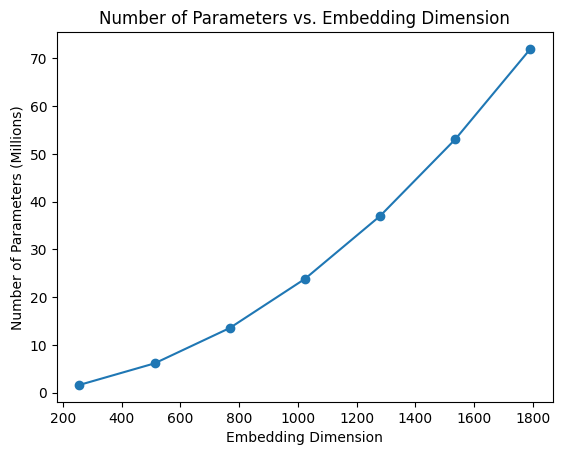

In [ ]:
# TODO: Plot the number of parameters vs. embedding dimension (in multiples of 256, capped at 1792)
emb_dims = [256 * i for i in range(1, 8)]  # multiples of 256, capped at 1792
num_params = []

for emb_dim in emb_dims:
    config = Config(emb_dim=emb_dim)

    # Create the model based on the current configuration
    model = MiniGPT(config)

    # Calculate the number of parameters and append to the list
    num_params_ = get_params(model)
    num_params.append(num_params_)

# Plot the results
plt.plot(emb_dims, num_params, marker='o')
plt.title('Number of Parameters vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Number of Parameters (Millions)')
plt.show()

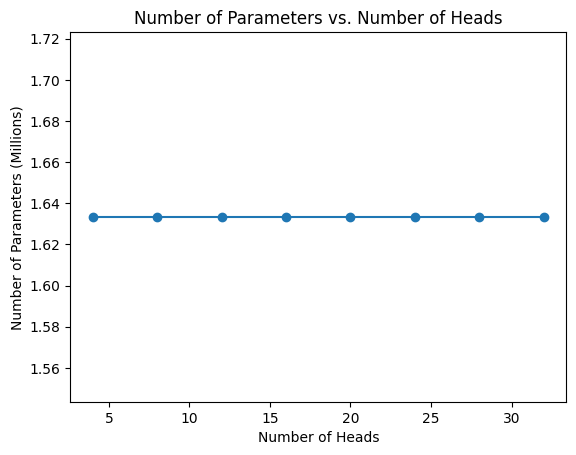

In [ ]:
# Explore the effect of the number of heads on the number of parameters
num_heads_list = [4 * i for i in range(1, 9)]  # multiples of 4, capped at 32
num_params_list_heads = []

for num_heads in num_heads_list:
    config = Config(num_heads=num_heads)

    # Create the model based on the current configuration
    model = MiniGPT(config)

    # Calculate the number of parameters and append to the list
    num_params_heads = get_params(model)
    num_params_list_heads.append(num_params_heads)

# Plot the results
plt.plot(num_heads_list, num_params_list_heads, marker='o')
plt.title('Number of Parameters vs. Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Number of Parameters (Millions)')
plt.show()


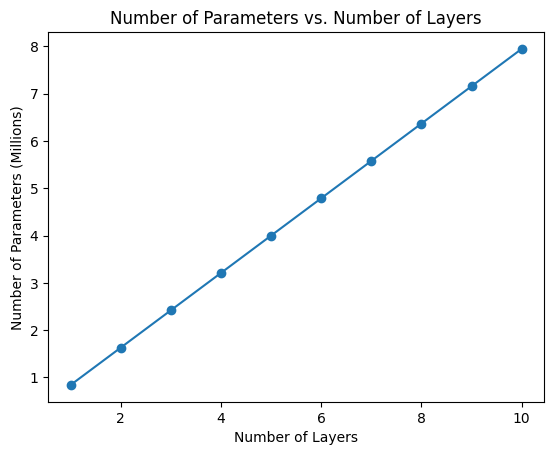

In [ ]:
# TODO: Plot the number of parameters vs. number of layers

num_layers_ = [i for i in range(1, 11)]
num_params = []

for num_layers in num_layers_:
    config = Config(num_layers=num_layers)

    # Create the model based on the current configuration
    model = MiniGPT(config)

    # Calculate the number of parameters and append to the list
    num_params_ = get_params(model)
    num_params.append(num_params_)

# Plot the results
plt.plot(num_layers_, num_params, marker='o')
plt.title('Number of Parameters vs. Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Number of Parameters (Millions)')
plt.show()


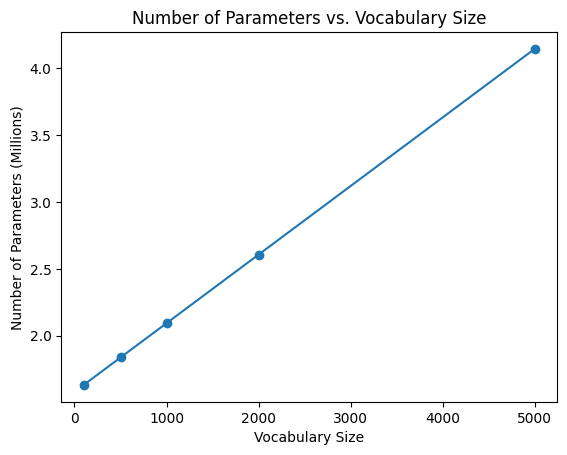

In [ ]:
# TODO: Plot the number of parameters vs. vocabulary size
vocab_size_ = [100, 500, 1000, 2000, 5000]  # example vocabulary size values
num_params = []

for vocab_size in vocab_size_:
    config = Config(vocab_size=vocab_size)

    # Create the model based on the current configuration
    model = MiniGPT(config)

    # Calculate the number of parameters and append to the list
    num_params_ = get_params(model)
    num_params.append(num_params_)

# Plot the results
plt.plot(vocab_size_, num_params, marker='o')
plt.title('Number of Parameters vs. Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Number of Parameters (Millions)')
plt.show()



After looking at these plots, can you answer which hyperparameters have the most effect on the number of parameters? Which ones have the least effect? Note that even if two plots indicate linearity, it is not necessary their gradients are the same :p

<span style="color: green">
    Number of heads has the least affect on the number of parameters since its aggregated at the end. Embedding Dimensions have the greatest affect on number of parameters. Its an exponential function which grows substantially on the increase of embedding dimentions
        
</span>

# Fin.